In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bp
%matplotlib inline

In [2]:
#Se lee la señal anteriormente procesada
data_set = pd.read_csv("../data/TrueFX/EUR-USD/datos_procesados_5T_EURUSD-2018-01.csv", parse_dates=True,
                      infer_datetime_format=True, index_col=0)

In [3]:
data_set.head()

,bid,ask
2018-01-02 00:00:00,1.20015,1.20110
2018-01-02 00:05:00,1.20047,1.20084
2018-01-02 00:10:00,1.20082,1.20126
2018-01-02 00:15:00,1.20035,1.20091
2018-01-02 00:20:00,1.20049,1.20085


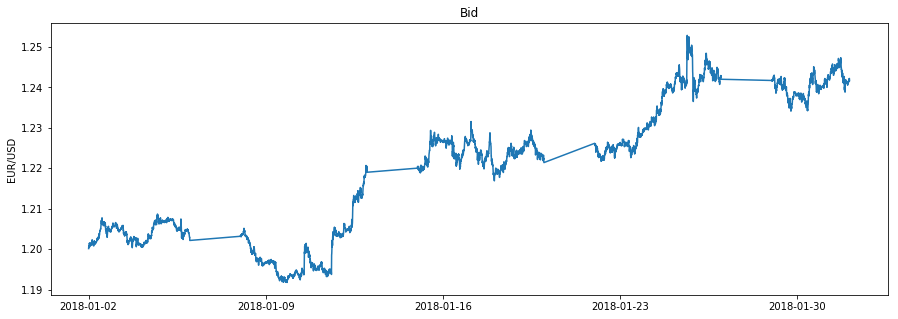

In [4]:
plt.figure(figsize=(15,5))
plt.title('Bid')
plt.ylabel('EUR/USD')
plt.plot(data_set.index,data_set.bid);

In [6]:
%run ../code/PNLEstimatorWrapper.py
%run ../code/EUtilities.py
EU = EUtilities()

In [7]:
window = 7
X, y_reg, bt = EU.build_dataset(data_set,window=window,bid_col='bid',binary_target=True,PNL=True)
X.shape

(6232, 9)

In [8]:
X.head()

,0,1,2,3,4,5,6,PNL_0,PNL_1
2018-01-02 00:30:00,1.20015,1.20047,1.20082,1.20035,1.20049,1.20047,1.20079,-0.00076,0.00022
2018-01-02 00:35:00,1.20047,1.20082,1.20035,1.20049,1.20047,1.20079,1.20135,-0.00023,-0.00012
2018-01-02 00:40:00,1.20082,1.20035,1.20049,1.20047,1.20079,1.20135,1.20143,-0.00020,-0.00009
2018-01-02 00:45:00,1.20035,1.20049,1.20047,1.20079,1.20135,1.20143,1.20149,-0.00007,-0.00030
2018-01-02 00:50:00,1.20049,1.20047,1.20079,1.20135,1.20143,1.20149,1.20133,-0.00028,-0.00017


In [9]:
print('numeros de 1: ', np.mean(bt==1))
print('numeros de 0: ', np.mean(bt==0))
print('numeros de 2: ', np.mean(bt==2))
print('numeros de 3: ', np.mean(bt==3))

numeros de 1:  0.43998716303
numeros de 0:  0.431001283697
numeros de 2:  0.0641848523748
numeros de 3:  0.0648267008986


In [10]:
np.mean(bt==2)/np.mean(bt==1)

0.14587892049598833

In [20]:
from sklearn.naive_bayes import GaussianNB
    
y = bt
n_bdtrain = 4
n_bdtest = 1
mday = 1
wc0 = 0.20 #peso de la clase 0
wc1 = 0.20 #peso de la clase 1
wc2 = 0.30 #peso de la clase 2
wc3 = 0.30 #peso de la clase 3
#para indexar el dataframe por las fechas
dates = np.unique(X.index.date)[n_bdtrain:]
est_GNB = PNLEstimatorWrapper(GaussianNB(priors=(wc0,wc1,wc2,wc3)), PNL_column=['PNL_0','PNL_1'])
result_GNB = EU.step_validation(est_GNB, X, y, EU.v_split(X,n_bdtrain,n_bdtest,mday))
result_GNB, predict_GNB = EU.redim(result_GNB)
print('--------- GaussianNB 5T ----------------')
print('average PNL : ', np.mean(result_GNB[:,0]))
print('average buy: ', np.mean(result_GNB[:,1]))
print('average sell: ', np.mean(result_GNB[:,2]))
print('longest_buy: ', np.max(result_GNB[:,3]))
print('longest_sell: ', np.max(result_GNB[:,4]))
print('%correct_1: ', np.mean(result_GNB[:,5]))
print('%correct_0: ', np.mean(result_GNB[:,6]))
print('%correct_3: ', np.mean(result_GNB[:,7]))
print('%correct_2: ', np.mean(result_GNB[:,8]))
print('% correct total: ', np.mean(result_GNB[:,5]+result_GNB[:,6]+result_GNB[:,7]+result_GNB[:,8]))
print('-------------------------------------')
df_GNB = pd.DataFrame(result_GNB, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
wc0 = np.ones(len(result_GNB))*wc0
wc1 = np.ones(len(result_GNB))*wc1
wc2 = np.ones(len(result_GNB))*wc2
wc3 = np.ones(len(result_GNB))*wc3

df_GNB.insert(loc=9,column='wc0',value=wc0)
df_GNB.insert(loc=10,column='wc1',value=wc1)
df_GNB.insert(loc=11,column='wc2',value=wc2)
df_GNB.insert(loc=12,column='wc3',value=wc3)

print(df_GNB)
df_GNB.to_csv('../resultados/TrueFX/EUR-USD/GaussianNB/pnl_5T_GNB_NC4_wsize7_2018-01.csv')

--------- GaussianNB 5T ----------------
average PNL :  -0.00238391304348
average buy:  105.739130435
average sell:  116.434782609
longest_buy:  286.0
longest_sell:  287.0
%correct_1:  0.147834292466
%correct_0:  0.0326268191646
%correct_3:  0.0533692567342
%correct_2:  0.0277259265655
% correct total:  0.261556294931
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells  %correct_1  \
2018-01-06  0.00000    1.0    0.0           0.0            1.0    0.000000   
2018-01-08 -0.00030  256.0   23.0          17.0          221.0    0.025090   
2018-01-09 -0.01243  283.0    0.0         283.0            0.0    0.424028   
2018-01-10 -0.00549  260.0   21.0         151.0           47.0    0.313167   
2018-01-11  0.00038  163.0  119.0         109.0          106.0    0.251773   
2018-01-12  0.00000    7.0  273.0           0.0          280.0    0.000000   
2018-01-13 -0.00138    1.0    0.0           1.0            0.0    0.000000   
2018-01-15  0.0000

In [21]:
print('Porcentaje de cada aparición de las clases')
print('------------------------------------------')
print('numeros de 1: ', np.mean(predict_GNB==1))
print('numeros de 0: ', np.mean(predict_GNB==0))
print('numeros de 2: ', np.mean(predict_GNB==2))
print('numeros de 3: ', np.mean(predict_GNB==3))

Porcentaje de cada aparición de las clases
------------------------------------------
numeros de 1:  0.30469667319
numeros de 0:  0.0909980430528
numeros de 2:  0.433072407045
numeros de 3:  0.171232876712


In [23]:
from sklearn.neighbors import KNeighborsClassifier

est_KNC = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=7,n_jobs=2,leaf_size=30
                                                   ,algorithm='kd_tree',weights='distance'), PNL_column=['PNL_0','PNL_1'])
result_KNC = EU.step_validation(est_KNC, X, y, EU.v_split(X,n_bdtrain,n_bdtest,mday))
result_KNC, predict_KNC = EU.redim(result_KNC)
print('--------- KNeighbors 5T ----------------')
print('average PNL : ', np.mean(result_KNC[:,0]))
print('average buy: ', np.mean(result_KNC[:,1]))
print('average sell: ', np.mean(result_KNC[:,2]))
print('longest_buy: ', np.max(result_KNC[:,3]))
print('longest_sell: ', np.max(result_KNC[:,4]))
print('%correct_1: ', np.mean(result_KNC[:,5]))
print('%correct_0: ', np.mean(result_KNC[:,6]))
print('%correct_3: ', np.mean(result_KNC[:,7]))
print('%correct_2: ', np.mean(result_KNC[:,8]))
print('% correct total: ', np.mean(result_KNC[:,5]+result_KNC[:,6]+result_KNC[:,7]+result_KNC[:,8]))
print('-------------------------------------')
df_KNC = pd.DataFrame(result_KNC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
wc0 = 'distance'
wc1 = 'distance'
wc2 = 'distance'
wc3 = 'distance'

df_KNC.insert(loc=9,column='wc0',value=wc0)
df_KNC.insert(loc=10,column='wc1',value=wc1)
df_KNC.insert(loc=11,column='wc2',value=wc2)
df_KNC.insert(loc=12,column='wc3',value=wc3)

print(df_KNC)
df_KNC.to_csv('../resultados/TrueFX/EUR-USD/KNeighborsClassfier/pnl_5T_KNC_NC4_wsize7_2018-01.csv')

--------- KNeighbors 5T ----------------
average PNL :  -0.00872173913044
average buy:  108.347826087
average sell:  113.826086957
longest_buy:  150.0
longest_sell:  175.0
%correct_1:  0.206106975752
%correct_0:  0.162231013153
%correct_3:  0.00170201957611
%correct_2:  0.00511651469098
% correct total:  0.375156523173
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells  %correct_1  \
2018-01-06 -0.00057    1.0    0.0           1.0            0.0    0.000000   
2018-01-08 -0.01259  219.0   60.0         125.0            6.0    0.311828   
2018-01-09 -0.01255  171.0  112.0          26.0           18.0    0.247350   
2018-01-10 -0.01248  130.0  151.0          16.0           33.0    0.138790   
2018-01-11 -0.01256   92.0  190.0          10.0           37.0    0.127660   
2018-01-12 -0.00474  198.0   82.0         150.0           14.0    0.350000   
2018-01-13 -0.00138    1.0    0.0           1.0            0.0    0.000000   
2018-01-15 -0.000

In [24]:
print('Porcentaje de cada aparición de las clases')
print('------------------------------------------')
print('numeros de 1: ', np.mean(predict_KNC==1))
print('numeros de 0: ', np.mean(predict_KNC==0))
print('numeros de 2: ', np.mean(predict_KNC==2))
print('numeros de 3: ', np.mean(predict_KNC==3))

Porcentaje de cada aparición de las clases
------------------------------------------
numeros de 1:  0.47553816047
numeros de 0:  0.449315068493
numeros de 2:  0.0630136986301
numeros de 3:  0.012133072407


In [96]:
from sklearn.tree import DecisionTreeClassifier


wc0 = 0.2 #peso de la clase 0
wc1 = 0.2 #peso de la clase 1
wc2 = 0.3 #peso de la clase 2
wc3 = 0.3 #peso de la clase 3
est_DTC = PNLEstimatorWrapper(DecisionTreeClassifier(class_weight={0:wc0,1:wc1,2:wc2,3:wc3})
                              , PNL_column=['PNL_0','PNL_1'])
result_DTC = EU.step_validation(est_DTC, X, y, EU.v_split(X,n_bdtrain,n_bdtest,mday))
result_DTC, predict_DTC = EU.redim(result_DTC)
print('--------- DecisionTree 5T ----------------')
print('average PNL : ', np.mean(result_DTC[:,0]))
print('average buy: ', np.mean(result_DTC[:,1]))
print('average sell: ', np.mean(result_DTC[:,2]))
print('longest_buy: ', np.max(result_DTC[:,3]))
print('longest_sell: ', np.max(result_DTC[:,4]))
print('%correct_1: ', np.mean(result_DTC[:,5]))
print('%correct_0: ', np.mean(result_DTC[:,6]))
print('%correct_3: ', np.mean(result_DTC[:,7]))
print('%correct_2: ', np.mean(result_DTC[:,8]))
print('% correct total: ', np.mean(result_DTC[:,5]+result_DTC[:,6]+result_DTC[:,7]+result_DTC[:,8]))
print('-------------------------------------')
df_DTC = pd.DataFrame(result_DTC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
wc0 = np.ones(len(result_DTC))*wc0
wc1 = np.ones(len(result_DTC))*wc1
wc2 = np.ones(len(result_DTC))*wc2
wc3 = np.ones(len(result_DTC))*wc3

df_DTC.insert(loc=9,column='wc0',value=wc0)
df_DTC.insert(loc=10,column='wc1',value=wc1)
df_DTC.insert(loc=11,column='wc2',value=wc2)
df_DTC.insert(loc=12,column='wc3',value=wc3)

print(df_DTC)
df_DTC.to_csv('../resultados/TrueFX/EUR-USD/DecisionTreeClassifier/pnl_5T_DTC_NC4_wsize7_2018-01.csv')

--------- DecisionTree 5T ----------------
average PNL :  -0.00842695652174
average buy:  121.739130435
average sell:  100.434782609
longest_buy:  202.0
longest_sell:  244.0
%correct_1:  0.16534911802
%correct_0:  0.142777774033
%correct_3:  0.00401391814801
%correct_2:  0.00216248965795
% correct total:  0.314303299858
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells  %correct_1  \
2018-01-06 -0.00057    1.0    0.0           1.0            0.0    0.000000   
2018-01-08 -0.00655  220.0   59.0           7.0          122.0    0.046595   
2018-01-09 -0.01105  106.0  177.0          42.0          164.0    0.123675   
2018-01-10  0.00025  109.0  172.0          16.0           45.0    0.131673   
2018-01-11 -0.01087  122.0  160.0           4.0           15.0    0.131206   
2018-01-12  0.00601  217.0   63.0         171.0           25.0    0.385714   
2018-01-13 -0.00138    1.0    0.0           1.0            0.0    0.000000   
2018-01-15 -0.00

In [112]:
from sklearn.ensemble import RandomForestClassifier

wc0 = 1 #peso de la clase 0
wc1 = 1 #peso de la clase 1
wc2 = 3 #peso de la clase 2
wc3 = 3 #peso de la clase 3

est_RFC = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3,
                                                     class_weight={0:wc0,1:wc1,2:wc2,3:wc3})
                              ,PNL_column=['PNL_1','PNL_0'])
result_RFC = EU.step_validation(est_RFC, X, y, EU.v_split(X,4,1,1))
result_RFC, predict_RFC = EU.redim(result_RFC)
print('--------- RandomForest 5T ----------------')
print('average PNL : ', np.mean(result_RFC[:,0]))
print('average buy: ', np.mean(result_RFC[:,1]))
print('average sell: ', np.mean(result_RFC[:,2]))
print('longest_buy: ', np.max(result_RFC[:,3]))
print('longest_sell: ', np.max(result_RFC[:,4]))
print('%correct_1: ', np.mean(result_RFC[:,5]))
print('%correct_0: ', np.mean(result_RFC[:,6]))
print('%correct_3: ', np.mean(result_RFC[:,7]))
print('%correct_2: ', np.mean(result_RFC[:,8]))
print('% correct total: ', np.mean(result_RFC[:,5]+result_RFC[:,6]+result_RFC[:,7]+result_RFC[:,8]))
print('-------------------------------------')
df_RFC = pd.DataFrame(result_RFC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
wc0 = np.ones(len(result_RFC))*wc0
wc1 = np.ones(len(result_RFC))*wc1
wc2 = np.ones(len(result_RFC))*wc2
wc3 = np.ones(len(result_RFC))*wc3

df_RFC.insert(loc=9,column='wc0',value=wc0)
df_RFC.insert(loc=10,column='wc1',value=wc1)
df_RFC.insert(loc=11,column='wc2',value=wc2)
df_RFC.insert(loc=12,column='wc3',value=wc3)

print(df_RFC)
df_RFC.to_csv('../resultados/TrueFX/EUR-USD/RandomForestClassifier/pnl_5T_RFC_NC4_wsize7_2018-01.csv')

--------- RandomForest 5T ----------------
average PNL :  -0.00682956521739
average buy:  111.173913043
average sell:  111.0
longest_buy:  173.0
longest_sell:  243.0
%correct_1:  0.159853029376
%correct_0:  0.159982558489
%correct_3:  0.00262214294161
%correct_2:  0.00419254658385
% correct total:  0.32665027739
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells  %correct_1  \
2018-01-06 -0.00057    1.0    0.0           1.0            0.0    0.000000   
2018-01-08 -0.00928   62.0  217.0          10.0          162.0    0.060932   
2018-01-09 -0.01243  267.0   16.0         173.0            5.0    0.399293   
2018-01-10 -0.01409   99.0  182.0          17.0           37.0    0.142349   
2018-01-11 -0.01363   81.0  201.0           5.0           32.0    0.120567   
2018-01-12  0.00563  224.0   56.0         170.0           12.0    0.417857   
2018-01-13 -0.00138    1.0    0.0           1.0            0.0    0.000000   
2018-01-15 -0.00227   30